In [7]:
import cv2
from util import plot_images
from preprocessing import hair_removal, get_mask_dark_corners
import numpy as np
%load_ext autoreload
%autoreload 2


# Read the input image
image_1 = cv2.imread('./data/test/malignant/44.jpg')
image_2 = cv2.imread('./data/test/malignant/1495.jpg')
image_3 = cv2.imread("./data/test/malignant/364.jpg")


# Convert the image to grayscale (optional, depending on your needs)

# Apply a median filter with a specified kernel size
kernel_size = 5  # You can adjust this parameter based on the level of noise in your image
image_1_median_filtered_image = cv2.medianBlur(image_1, kernel_size)
image_2_median_filtered_image = cv2.medianBlur(image_2, kernel_size)
image_3_median_filtered_image = cv2.medianBlur(image_3, kernel_size)

image_1_removed_hair = hair_removal(image_1_median_filtered_image)
image_2_removed_hair = hair_removal(image_2_median_filtered_image)
image_3_removed_hair = hair_removal(image_3_median_filtered_image)

image_1_dark_corner_removed_image_mask = get_mask_dark_corners(image_1_removed_hair)
image_2_dark_corner_removed_image_mask = get_mask_dark_corners(image_2_removed_hair)
image_3_dark_corner_removed_image_mask = get_mask_dark_corners(image_3_removed_hair)


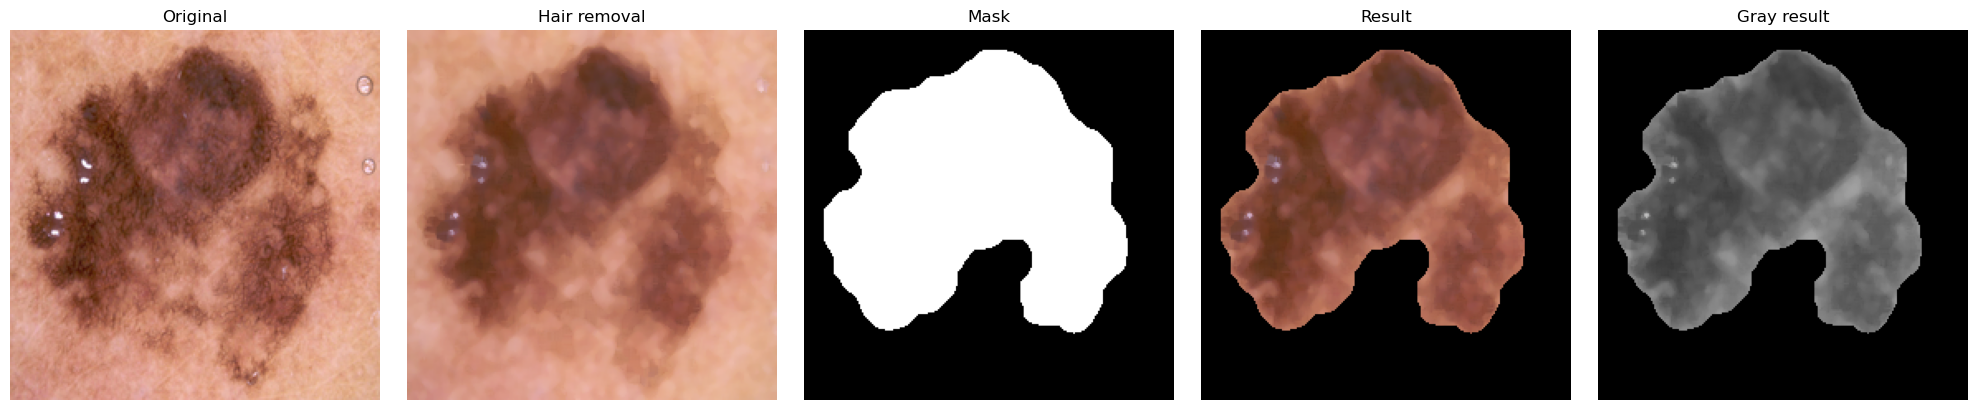

In [28]:
import cv2
import numpy as np

# Read the original image
image = cv2.imread('./data/train/malignant/975.jpg')
# image = cv2.imread('./data/train/malignant/886.jpg')

kernel_size = 5  # You can adjust this parameter based on the level of noise in your image
image_median_filtered_image = cv2.medianBlur(image, kernel_size)
image_removed_hair = hair_removal(image_median_filtered_image)

mask_dark_corners = get_mask_dark_corners(image_removed_hair)

# Convert the image to grayscale
gray = cv2.cvtColor(image_removed_hair, cv2.COLOR_BGR2GRAY)

# Otsu's thresholding
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# apply mask
binary = cv2.bitwise_and(binary, mask_dark_corners)

# Morphological opening to remove small objects
kernel_opening = np.ones((5, 5), np.uint8)
binary_opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_opening, iterations=1)

# Smoothen the lesion border using opening and closing operations
kernel_smoothening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
binary_smooth = cv2.morphologyEx(binary_opening, cv2.MORPH_OPEN, kernel_smoothening, iterations=1)
binary_smooth = cv2.morphologyEx(binary_smooth, cv2.MORPH_CLOSE, kernel_smoothening, iterations=1)

# inverse
binary_smooth = cv2.bitwise_not(binary_smooth)

result_image = cv2.bitwise_and(image_removed_hair, image_removed_hair, mask=binary_smooth)
gray_result = cv2.cvtColor(result_image, cv2.COLOR_BGR2GRAY)
# Display the results
result = [image, image_removed_hair, binary_smooth, result_image, gray_result]
labels = ["Original", "Hair removal", "Mask", "Result", "Gray result"]
plot_images(result, labels, 5, 1)


In [22]:
import cv2
import numpy as np
from scipy.stats import skew, kurtosis, entropy

def channel_statistics(image):
    # Split the image into its channels
    b, g, r = cv2.split(image)

    # Filter out black pixels
    non_black_indices = np.where((b > 0) & (g > 0) & (r > 0))

    # Extract non-black values for each channel
    b_non_black = b[non_black_indices]
    g_non_black = g[non_black_indices]
    r_non_black = r[non_black_indices]

    # Calculate mean, variance, skewness, kurtosis, and entropy for each channel
    mean_b, mean_g, mean_r = np.mean(b_non_black), np.mean(g_non_black), np.mean(r_non_black)
    var_b, var_g, var_r = np.var(b_non_black), np.var(g_non_black), np.var(r_non_black)
    skew_b, skew_g, skew_r = skew(b_non_black.flatten()), skew(g_non_black.flatten()), skew(r_non_black.flatten())
    kurt_b, kurt_g, kurt_r = kurtosis(b_non_black.flatten()), kurtosis(g_non_black.flatten()), kurtosis(r_non_black.flatten())
    entropy_b, entropy_g, entropy_r = entropy(b_non_black.flatten()), entropy(g_non_black.flatten()), entropy(r_non_black.flatten())

    # Return the calculated values
    return {
        'mean_b': mean_b, 'mean_g': mean_g, 'mean_r': mean_r,
        'var_b': var_b, 'var_g': var_g, 'var_r': var_r,
        'skew_b': skew_b, 'skew_g': skew_g, 'skew_r': skew_r,
        'kurt_b': kurt_b, 'kurt_g': kurt_g, 'kurt_r': kurt_r,
        'entropy_b': entropy_b, 'entropy_g': entropy_g, 'entropy_r': entropy_r
    }


# Calculate channel statistics
statistics = channel_statistics(image_smooth)

# Print the results
for key, value in statistics.items():
    print(f"{key}: {value}")


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
mean_b: 28.672731983418366
mean_g: 35.37396364795919
mean_r: 61.23022959183673
var_b: 1247.3830702307816
var_g: 1831.709880144087
var_r: 5288.77025645239
skew_b: 0.6453644197248435
skew_g: 0.5745091000762823
skew_r: 0.45583509294509944
kurt_b: -1.1150398751292958
kurt_g: -1.2744125863458349
kurt_r: -1.5792152015031624
entropy_b: 9.935657105511687
entropy_g: 9.94917205278271
entropy_r: 9.959741266473381


In [37]:
import cv2
import numpy as np
from skimage.feature import graycomatrix
from skimage.feature import graycoprops


# Specify the distances and angles for GLCM computation
distances = [1, 2, 3]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Compute GLCM
glcm = graycomatrix(gray_result, distances=distances, angles=angles, symmetric=True, normed=True)

# Calculate texture features
contrast = graycoprops(glcm, 'contrast')
energy = graycoprops(glcm, 'energy')
homogeneity = graycoprops(glcm, 'homogeneity')
correlation = graycoprops(glcm, 'correlation')

# Print the calculated features
print("Contrast:", np.nanmean(contrast))
print("Energy:", np.nanmean(energy))
print("Homogeneity:", np.nanmean(homogeneity))
print("Correlation:", np.nanmean(correlation))


Contrast: 304.99437808941144
Energy: 0.5584917504344689
Homogeneity: 0.671726749265814
Correlation: 0.941142896814496


In [60]:
import cv2
import numpy as np
from skimage import exposure
from sklearn.decomposition import PCA

# Load the image
image = cv2.imread('./data/test.jpg')


# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute HOG features
win_size = (64, 64)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
nbins = 9

hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
features = hog.compute(gray)
features = features.flatten()

# Optionally, normalize the HOG features
features = exposure.rescale_intensity(features, in_range=(0, 10))
print(features)
print(features.shape)


[0.03002996 0.02587032 0.02102808 ... 0.00646428 0.00210921 0.0099478 ]
(18627840,)


In [65]:
n_components = 64  # Choose the number of components you want to keep
pca = PCA(n_components=n_components)
features_2d = features.reshape(1, -1)  # Convert to 2D array
print(features_2d)
# features_pca = pca.fit_transform(features_2d)

# The reduced feature vector
# features_reduced = features_pca.flatten()

# print(features_reduced)

[[0.03002996 0.02587032 0.02102808 ... 0.00646428 0.00210921 0.0099478 ]]


In [74]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
image = gray_result

# Create HOG descriptor
hog_features = hog.compute(image)
# Compute HOG features
# Reshape to 2D array based on block size
win_size = (64, 64)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
nbins = 9
hog_features_2d = hog_features.reshape(image.shape[0] // block_size[0], image.shape[1] // block_size[1], -1)

print(hog_features_2d)

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.86108737e-05
   0.00000000e+00 5.53964339e-02]
  [1.10609028e-02 2.19151974e-01 3.66691947e-01 ... 2.06126556e-01
   2.85313666e-01 1.15654252e-01]
  [7.21127316e-02 2.51681786e-02 2.30664089e-02 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [2.97894794e-02 1.08267721e-02 6.02465309e-03 ... 7.78280422e-02
   9.00984481e-02 1.89173952e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.54946547e-03
   2.60963733e-03 2.06382889e-02]
  [1.55241698e-01 1.67903468e-01 2.50088543e-01 ... 4.36563492e-01
   4.36563492e-01 4.05446813e-02]]

 [[3.74076073e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.65413174e-02
   4.08329256e-02 3.61032896e-02]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.15640260e-01
   6.13393039e-02 6.49130195e-02]
  ...
  [2.55868863e-02 3.11568752e-02 2.05129460e-01 ... 1.04173884e-01
   4.30479

(210, 9)


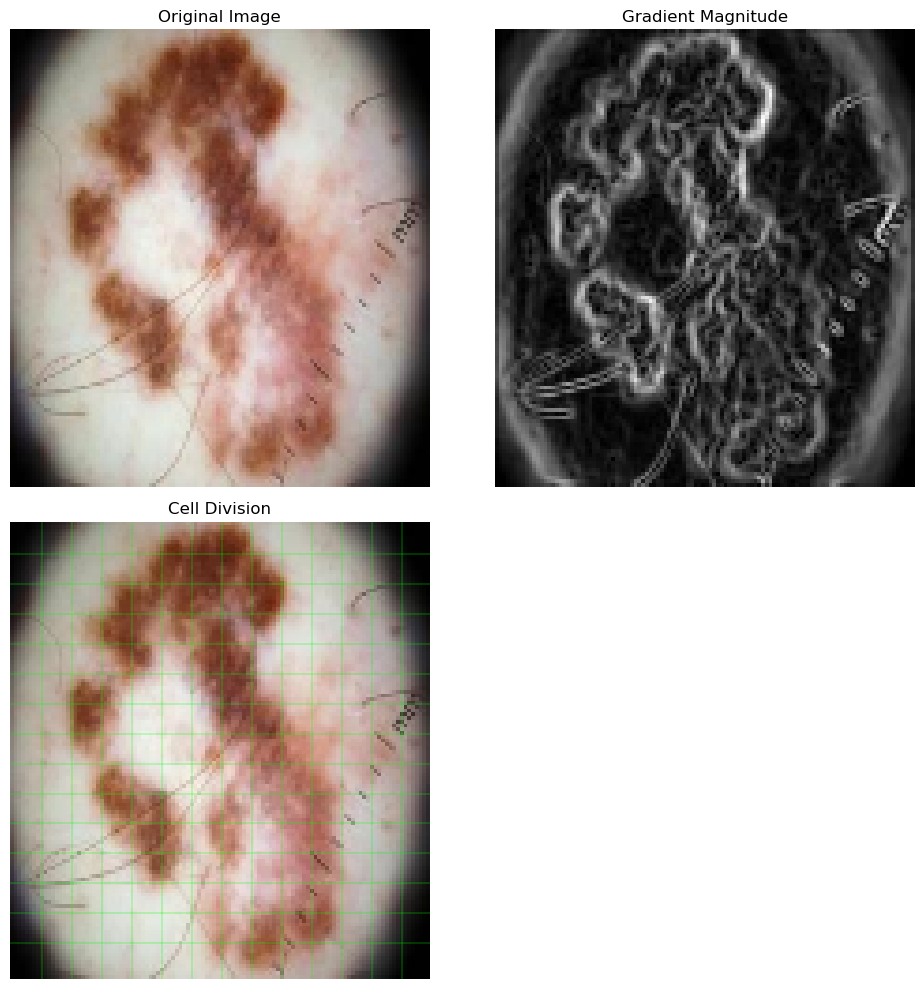

(210, 9)


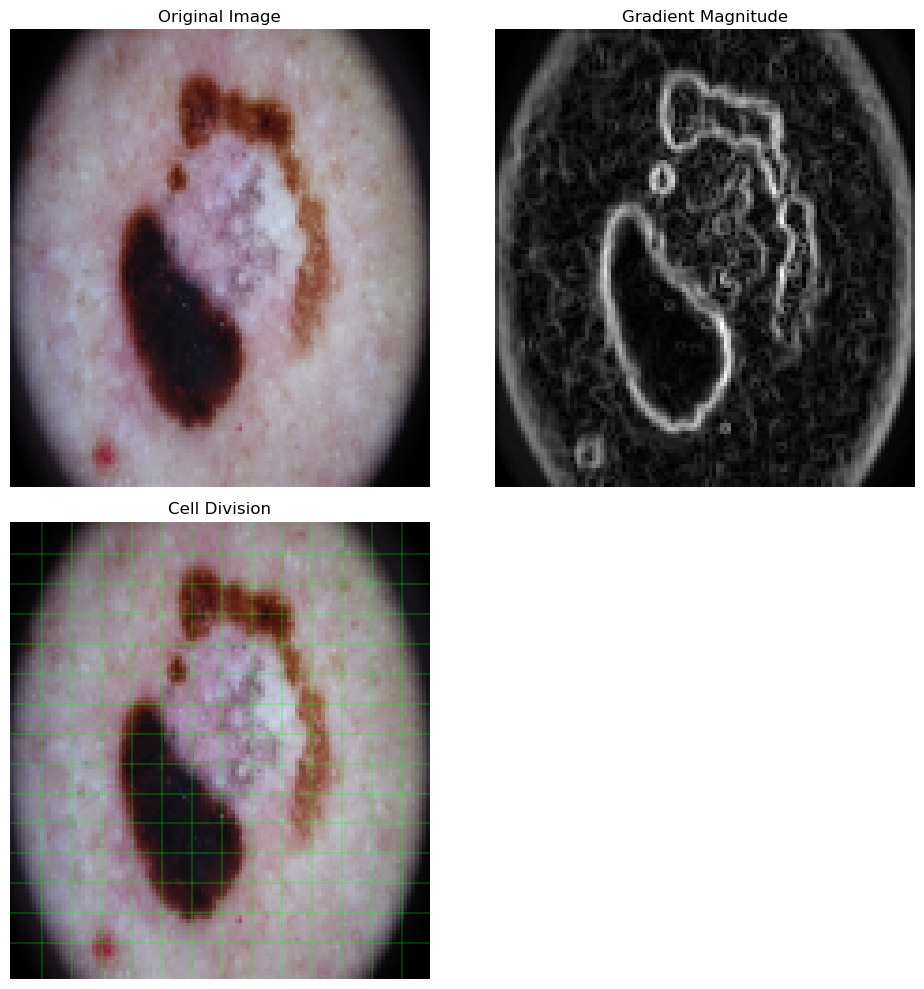

(210, 9)


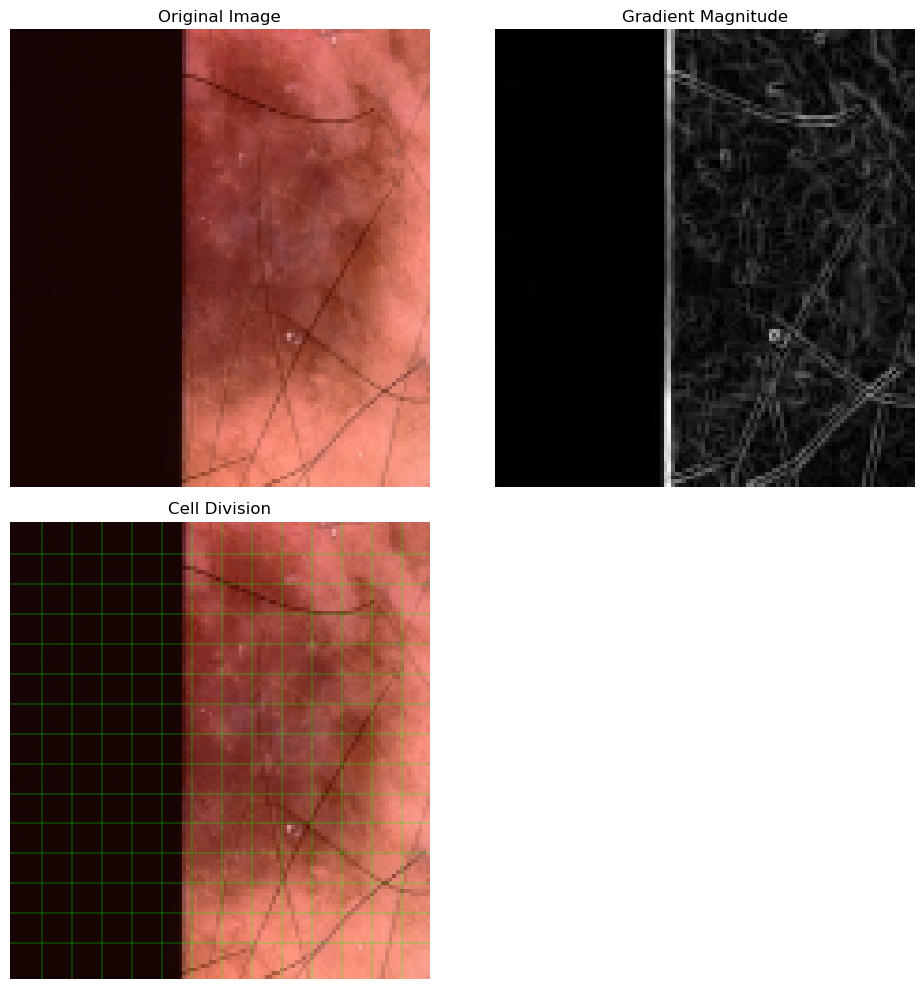

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, color, filters, feature

import matplotlib.pyplot as plt

def visualize_hog(image_path):
    # Step 1: Import the image
    image = io.imread(image_path)
    image = cv2.resize(image, (112, 122))

    # Plot the original image
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Step 2: Image gradient computation
    gray = color.rgb2gray(image)
    gradient_x = filters.sobel_h(gray)
    gradient_y = filters.sobel_v(gray)
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)

    # Plot the gradient magnitude
    plt.subplot(2, 2, 2)
    plt.imshow(gradient_magnitude, cmap='gray')
    plt.title("Gradient Magnitude")
    plt.axis('off')

    # Step 3: Image cell division
    cell_size = (8, 8)
    num_cells_x = gray.shape[1] // cell_size[1]
    num_cells_y = gray.shape[0] // cell_size[0]

    # Plot the original image with divided cells
    plt.subplot(2, 2, 3)
    plt.imshow(image)
    for i in range(1, num_cells_x):
        plt.axvline(i * cell_size[1], color='lime', linewidth=0.3)
    for i in range(1, num_cells_y):
        plt.axhline(i * cell_size[0], color='lime', linewidth=0.3)
    plt.title("Cell Division")
    plt.axis('off')

    features, hog_image = feature.hog(gray, visualize=True, cells_per_block=(1, 1))
    
    # Reshape the 1D array to the original HOG descriptor shape
    hog_descriptor_shape = (num_cells_y, num_cells_x, -1)
    hog_features = features.reshape(hog_descriptor_shape)

    # Add label for each feature
    labels = []
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            labels.append(f"{i}, {j}")

    # Reshape the HOG features to a 2D array
    hog_features_2d = hog_features.reshape(-1, hog_features.shape[2])
    print(hog_features_2d.shape)
    # Concatenate the HOG features for each cell into a single row
    # columns = [f'HOG_{i}_{label}' for i in range(hog_features.shape[2]) for label in labels]
    # df = pd.DataFrame(data=[hog_features_2d.flatten()], columns=columns)
    # display(df)
    
    # # Assuming df is your DataFrame with HOG features
    # # Specify the number of components you want to keep (e.g., 10 for demonstration purposes)
    # n_components = 10

    # # Extract the HOG features from the DataFrame
    # hog_features_data = df.values

    # # Apply PCA
    # pca = PCA(n_components=n_components)
    # pca_result = pca.fit_transform(hog_features_data)

    # # Create a new DataFrame with the PCA results
    # pca_columns = [f'PCA_{i}' for i in range(1, n_components + 1)]
    # df_pca = pd.DataFrame(data=pca_result, columns=pca_columns)

    # # Add the 'Cell_Label' column to the new DataFrame

    # # Display the DataFrame with PCA results
    # display(df_pca)
    
    # flattened_hog_features = hog_features[:, :, 0].flatten()
    # pca = PCA(n_components=num_components)
    # hog_features_pca = pca.fit_transform(flattened_hog_features.reshape(-1, 1).T)
    
    # # Plot the reshaped HOG features as a table
    # plt.subplot(2, 2, 4)
    # plt.axis('off')
    # plt.table(cellText=hog_features[:, :, 0], loc='center', cellLoc='center', colLabels=None)
    # plt.title("HOG Features")

    plt.tight_layout()
    plt.show()
num_components = 64
csv_output_path = "./hog_features.csv"
image_1 = visualize_hog('./data/test/malignant/44.jpg')
image_2 = visualize_hog('./data/test/malignant/1495.jpg')
image_3 = visualize_hog("./data/test/malignant/364.jpg")
# visualize_hog('./data/test/benign/1.jpg')

In [149]:
import os
import cv2

folder_path = "data/test/malignant"
images = []
# Check if the folder exists
if not os.path.exists(folder_path):
    print(f"The folder '{folder_path}' does not exist.")
else:
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Iterate through each file in the folder
    for file_name in files:
        # Construct the full path to the image file
        file_path = os.path.join(folder_path, file_name)

        # Check if the file is a valid image file
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Read the image using OpenCV
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            resized_image = cv2.resize(image, (112, 122))
            images.append(resized_image)
        else:
            print(f"Skipping non-image file: {file_name}")
  
print(len(images))


300


In [146]:
import cv2
from skimage.feature import hog
from skimage import exposure

# Load your image
image_features = []

for image in images:
    # Compute HOG features
    features, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                            cells_per_block=(1, 1), visualize=True, multichannel=False)

    # Optionally, you can enhance the visualization of HOG features
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    image_features.append(features)

# import numpy as np

# # Reshape the HOG features for PCA
# features = features.reshape(-1, 1)

# print(features.shape)

# # perform PCA
# pca = PCA(n_components=100)
# pca_result = pca.fit_transform(features)
# print(pca_result.shape)


C:\Users\drith\AppData\Local\Temp\ipykernel_6636\3076546126.py:10: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),


ValueError: Expected 2D array, got 1D array instead:
array=[0.3958169  0.31562824 0.3958169  ... 0.38018416 0.38018416 0.38018416].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [148]:
pca = PCA(n_components=100)
pca_result = pca.fit_transform(image_features)

print(pca_result.shape)

(300, 100)


In [135]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# randomize x
np.random.seed(42)
X = np.random.rand(1, 3456)
print(X.shape)
# Assuming X is your HOG data matrix with shape (num_samples, 3456)
# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=100)  # Choose the number of components you want
X_pca = pca.fit_transform(X_standardized)
X_pca.shape
# X_pca now contains the reduced-dimensional representation of your data


(1, 3456)


ValueError: n_components=100 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'